In [4]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

#### 95th percentile  treshold

In [5]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2024-1-1", k=10):
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=['date'])
    if df.empty:
        return None

    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    df['timestamp'] = df['date'].astype('datetime64[s]')
    df = df.sort_values(by=['timestamp'], ascending=True)

    if len(df) > k:
        df = df.iloc[-k:]

    df['interval'] = df['timestamp'].diff().dt.total_seconds()

    # Update with percentile-based thresholds
    alive_threshold = df['interval'].quantile(0.75)  # 75th percentile for "alive"
    grace_period_threshold = df['interval'].quantile(0.99)  # 90th percentile as a buffer

    mean_interval = df['interval'].mean()
    sd_interval = df['interval'].std()
    Z = df['interval'].max()
    percentile_95 = df['interval'].quantile(0.95)
    T = pd.to_datetime(current_time)
    T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
    time_since_last_commit_days = T_X_n / (60 * 60 * 24)

    classification = "unknown"
    if T_X_n < alive_threshold:
        classification = "alive"
    elif T_X_n < grace_period_threshold:
        # Consider within grace period still "alive" if not too far from mean_interval
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
        else:
            classification = "dead"
    else:
        classification = "dead"

    mean_interval_days = mean_interval / (60 * 60 * 24)
    
    repo_name = os.path.basename(csv_file).split('.')[0]
    return {
        'Repo': repo_name,
        'Z': Z,
        'T_X_n': T_X_n,
        'Percentile_95': percentile_95,
        'MeanInterval(days)': mean_interval_days,
        'SDInterval': sd_interval,
        'Classification': classification,
        'TimeSinceLastCommit(days)': time_since_last_commit_days
    }
    
folder_path = '/Users/ethan/Documents/Data science/MQP/main_repo_df/Data/CommitData'  
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

# Use pd.concat to create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)



C:\Users\ethan\AppData\Local\Temp\ipykernel_4228\4018353815.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
C:\Users\ethan\AppData\Local\Temp\ipykernel_4228\4018353815.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


    classification = "unknown"
    if T_X_n > Z:
        classification = "dead"
        # If classified as dead but within 1 SD from the mean, reclassify as alive
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
    elif T_X_n < percentile_95:
        classification = "alive"
   

In [6]:
results_df.head(1)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,1332409.2,5.115152,550708.876429,dead,858.4439


In [7]:
results_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,1332409.2,5.115152,5.507089e+05,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,8628677.8,43.319947,3.573628e+06,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,21445419.6,51.277137,1.028525e+07,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,6771796.6,24.753252,3.121891e+06,dead,1475.003333
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,57116124.8,142.666732,2.479288e+07,alive,114.686644
...,...,...,...,...,...,...,...,...
1746,C_zpao_qrcode,4817462.0,696362.0,4468180.0,11.633110,1.928512e+06,alive,8.059745
1747,C_zqzess_rule_for_quantumultX,375383.0,577893.0,316082.2,0.804852,1.365385e+05,dead,6.688576
1748,C_zs9024_quick_psd2ugui,10850856.0,57677255.0,6691764.8,15.090710,3.583334e+06,dead,667.560822
1749,C_zxing_zxing,614301.0,2371857.0,610625.0,3.109478,3.186023e+05,dead,27.452049


In [8]:
results_df['TimeSinceLastCommit(days)'].describe()

count    1751.000000
mean      731.497174
std       932.519463
min         1.510486
25%        32.896117
50%       283.446366
75%      1181.003287
max      5020.900463
Name: TimeSinceLastCommit(days), dtype: float64

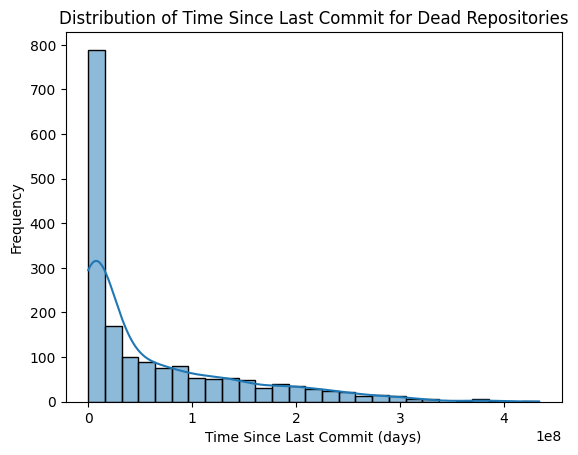

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['T_X_n'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


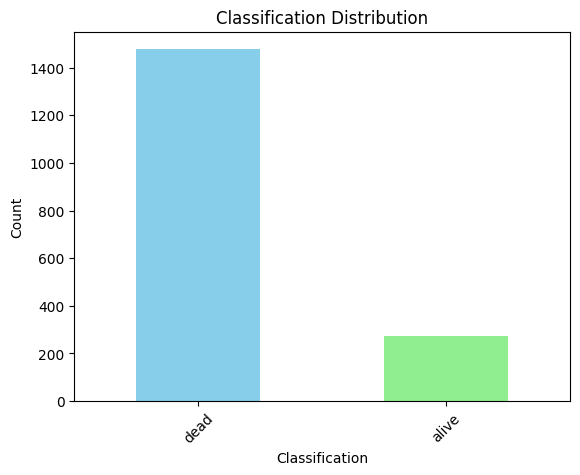

In [10]:
import matplotlib.pyplot as plt

classification_counts = results_df['Classification'].value_counts()
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Classification Distribution')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Dead repos 

In [11]:
dead_repos_df = results_df[results_df['Classification'] == 'dead']
dead_repos_df.head(10)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,1332409.20,5.115152,5.507089e+05,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,8628677.80,43.319947,3.573628e+06,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,21445419.60,51.277137,1.028525e+07,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,6771796.60,24.753252,3.121891e+06,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,207744379.0,37486232.60,97.620000,1.711650e+07,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,128771801.0,356.00,0.004120,NaN,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,57097704.0,22938332.75,68.840289,1.124620e+07,dead,660.853056
11,C_academind_node-restful-api-tutorial,126883.0,192108057.0,120851.95,0.770515,8.529193e+04,dead,2223.472882
12,C_acmerobotics_road-runner-quickstart,809457.0,609549.0,662714.60,3.114713,2.495928e+05,dead,7.054965
13,C_activeadmin_activeadmin,641697.0,661900.0,418692.60,1.003023,2.100131e+05,dead,7.660880


In [19]:
dead_repos_df.describe()

,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,TimeSinceLastCommit(days)
count,1.477000e+03,1.477000e+03,1.477000e+03,1477.000000,1.459000e+03,1477.000000
mean,1.573519e+07,7.358552e+07,1.162164e+07,32.957863,5.504421e+06,851.684276
std,2.490207e+07,8.359353e+07,1.733326e+07,46.919463,8.490029e+06,967.517673
min,3.800000e+01,1.601700e+05,3.640000e+01,0.000174,6.184658e+00,1.853819
25%,8.548080e+05,4.845411e+06,6.431352e+05,2.082672,3.089315e+05,56.081146
50%,5.360984e+06,3.900028e+07,4.152951e+06,11.609456,1.936291e+06,451.392141
75%,2.086903e+07,1.194717e+08,1.529623e+07,45.659990,7.414485e+06,1382.774051
max,2.547976e+08,4.338058e+08,1.597367e+08,361.899651,8.400991e+07,5020.900463


In [12]:

# Selecting a random row from `dead_repos_df`
random_row = dead_repos_df.sample(n=1)
random_row

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
259,C_CyanogenMod_android_hardware_qcom_display,3564211.0,223072919.0,2207609.0,5.16606,1.170544e+06,dead,2581.862488


In [13]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit(days)')
sorted_dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1215,C_qsaker_QtSwissArmyKnife,143573.0,160170.0,87483.8,0.195231,4.752404e+04,dead,1.853819
240,C_connamara_quickfixn,89106.0,204059.0,71452.8,0.212531,3.010655e+04,dead,2.361794
195,C_chengyangkj_Ros_Qt5_Gui_App,3992.0,219493.0,3908.8,0.013461,1.566123e+03,dead,2.540428
1174,C_qdleader_qdleader,86553.0,246519.0,69227.8,0.172824,3.034824e+04,dead,2.853229
1609,C_uwerat_qskinny,408059.0,286416.0,291186.6,0.683209,1.362882e+05,dead,3.315000
...,...,...,...,...,...,...,...,...
1137,C_punkave_phpQuery,364.0,382092634.0,364.0,0.004213,NaN,dead,4422.368449
875,C_lorensiuswlt_NewQuickAction3D,7033736.0,385339174.0,5798779.8,18.357984,3.067312e+06,dead,4459.944144
570,C_huacnlee_quora,771750.0,385840367.0,623318.0,1.946073,2.675076e+05,dead,4465.744988
1112,C_placemarker_jQuery-MD5,7546712.0,396091502.0,5972567.2,19.857190,2.504764e+06,dead,4584.392384


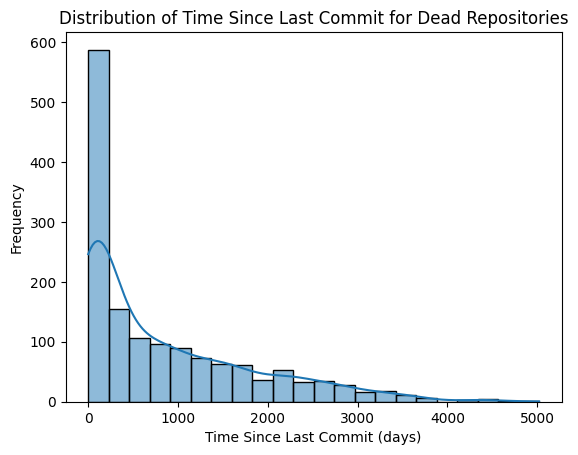

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(dead_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


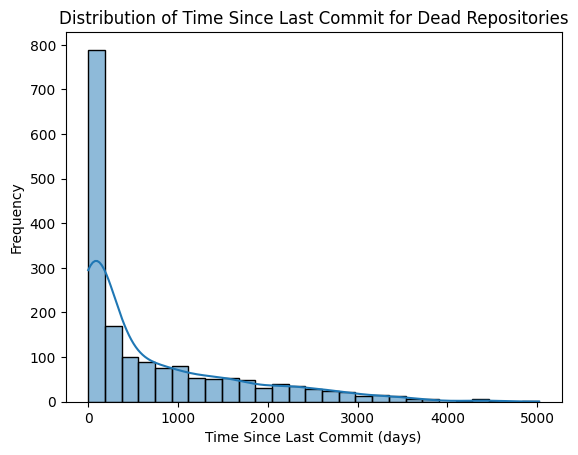

In [15]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [16]:
alive_repos_df = results_df[results_df['Classification'] == 'alive']
alive_repos_df.head(10)


,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,57116124.8,142.666732,2.479288e+07,alive,114.686644
5,C_78778443_QingScan,14194587.0,3143181.0,11428229.4,39.830201,5.044871e+06,alive,36.379410
6,C_89996462_Quantumult-X,596400.0,396044.0,565589.2,3.295703,2.457538e+05,alive,4.583843
8,C_aamirafridi_jQuery,64920542.0,31156632.0,62408318.4,174.432909,2.665004e+07,alive,360.609167
29,C_airbus-seclab_qemu_blog,20629707.0,5057537.0,19365705.0,70.925926,8.568165e+06,alive,58.536308
31,C_aizvorski_video-quality,118991936.0,4859445.0,102952822.4,351.258731,4.330795e+07,alive,56.243576
35,C_alex-spataru_QSimpleUpdater,20919276.0,1133967.0,16724162.4,54.378292,6.988087e+06,alive,13.124618
36,C_alexa-samples_skill-sample-nodejs-quiz-game,82848861.0,22293993.0,55019226.2,137.550646,2.709586e+07,alive,258.032326
53,C_amefs_quickbox-lite,5599191.0,1845871.0,5242761.8,24.303659,2.151134e+06,alive,21.364248
55,C_amplitude_redux-query,8235140.0,1664530.0,4956725.2,10.670392,2.742492e+06,alive,19.265394


In [17]:
# Selecting a random row from `dead_repos_df`
random_row = alive_repos_df.sample(n=1)
random_row

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1711,C_yegor256_quiz,129080442.0,28585171.0,1.201521e+08,365.446076,5.305989e+07,alive,330.846887


In [21]:
alive_repos_df.describe()

,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,TimeSinceLastCommit(days)
count,2.740000e+02,2.740000e+02,2.740000e+02,274.000000,2.730000e+02,274.000000
mean,3.258362e+07,7.225398e+06,2.459891e+07,76.682199,1.115622e+07,83.627288
std,4.243350e+07,1.015965e+07,3.065139e+07,147.728934,1.427391e+07,117.588530
min,5.964000e+05,1.305060e+05,4.688678e+05,1.316371,1.780493e+05,1.510486
25%,4.959189e+06,1.191996e+06,4.295934e+06,13.009324,1.833349e+06,13.796244
50%,1.435747e+07,2.786866e+06,1.197498e+07,36.484666,5.044871e+06,32.255388
75%,4.422391e+07,7.714729e+06,3.403795e+07,96.468822,1.511426e+07,89.290842
max,2.956571e+08,5.913896e+07,1.829573e+08,2117.561007,9.822375e+07,684.478692


In [20]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit(days)', ascending=False)
sorted_alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1593,C_udacity_ud843-QuakeReport,182957271.0,59138959.0,1.829573e+08,2117.561007,NaN,alive,684.478692
1579,C_tvvocold_How-To-Ask-Questions-The-Smart-Way,154258970.0,54412381.0,1.367203e+08,516.587500,6.758521e+07,alive,629.772928
1564,C_tomnomnom_qsreplace,82187479.0,48051981.0,7.026392e+07,245.615961,4.066405e+07,alive,556.157187
1717,C_yireyun_go-queue,87686995.0,45345482.0,6.750780e+07,201.444799,2.899441e+07,alive,524.831968
550,C_harvesthq_chosen,84964808.0,39839721.0,6.265666e+07,172.323133,2.841631e+07,alive,461.107882
...,...,...,...,...,...,...,...,...
1423,C_shenwei356_seqkit,1472240.0,298895.0,1.245549e+06,4.463629,5.033326e+05,alive,3.459433
1189,C_qiskit-community_qiskit-metal,4044268.0,263663.0,2.500950e+06,5.623719,1.335989e+06,alive,3.051655
1176,C_qdrant_quaterion,23259267.0,212763.0,1.544541e+07,42.352064,7.451130e+06,alive,2.462535
1161,C_qbcore-framework_qb-phone,3115792.0,191893.0,2.662942e+06,10.769834,1.134682e+06,alive,2.220984


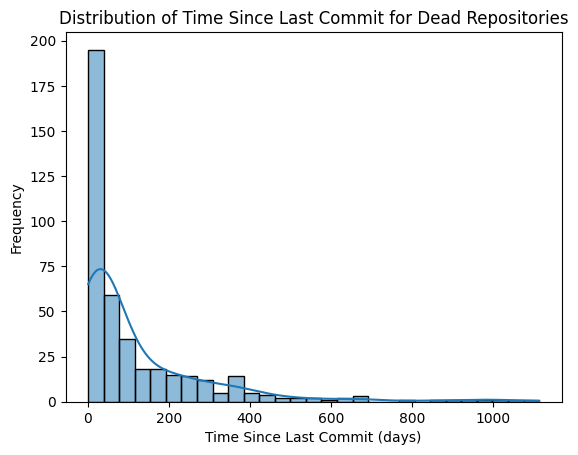

In [ ]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(alive_repos_df['TimeSinceLastCommit'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,1332409.20,5.115152,5.507089e+05,dead,858.443900
3,C_2d-inc_developer_quest,6848421.0,127440288.0,6771796.60,24.753252,3.121891e+06,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,207744379.0,37486232.60,97.620000,1.711650e+07,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,128771801.0,356.00,0.004120,NaN,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,57097704.0,22938332.75,68.840289,1.124620e+07,dead,660.853056
...,...,...,...,...,...,...,...,...
1743,C_ziadoz_awesome-php,2537785.0,45455853.0,2212891.00,5.944977,9.425046e+05,dead,526.109410
1745,C_Zoinkwiz_quest-helper,338283.0,1078846.0,312276.60,0.964230,1.301673e+05,dead,12.486644
1748,C_zs9024_quick_psd2ugui,10850856.0,57677255.0,6691764.80,15.090710,3.583334e+06,dead,667.560822
1749,C_zxing_zxing,614301.0,2371857.0,610625.00,3.109478,3.186023e+05,dead,27.452049


In [ ]:
unknown = results_df[results_df['Classification'] == 'unknown']

In [ ]:
alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval,SDInterval,Classification,TimeSinceLastCommit
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,57116124.8,142.666732,2.479288e+07,alive,114.686644
5,C_78778443_QingScan,14194587.0,3143181.0,11428229.4,39.830201,5.044871e+06,alive,36.379410
6,C_89996462_Quantumult-X,596400.0,396044.0,565589.2,3.295703,2.457538e+05,alive,4.583843
8,C_aamirafridi_jQuery,64920542.0,31156632.0,62408318.4,174.432909,2.665004e+07,alive,360.609167
12,C_acmerobotics_road-runner-quickstart,809457.0,609549.0,662714.6,3.114713,2.495928e+05,alive,7.054965
...,...,...,...,...,...,...,...,...
1727,C_yuanfengyun_q_algorithm,82610439.0,30574013.0,58026441.4,170.384574,2.629657e+07,alive,353.865891
1735,C_zeromicro_go-queue,14063486.0,7122496.0,9830823.6,23.584407,4.646386e+06,alive,82.436296
1737,C_zestyping_q,15849003.0,1126198.0,10371587.0,24.668194,5.200119e+06,alive,13.034699
1741,C_zhiyiYo_PyQt-Fluent-Widgets,1107150.0,671945.0,939227.6,2.548639,3.988693e+05,alive,7.777141


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Repo                       1751 non-null   object 
 1   Z                          1751 non-null   float64
 2   T_X_n                      1751 non-null   float64
 3   Percentile_95              1751 non-null   float64
 4   MeanInterval(days)         1751 non-null   float64
 5   SDInterval                 1732 non-null   float64
 6   Classification             1751 non-null   object 
 7   TimeSinceLastCommit(days)  1751 non-null   float64
dtypes: float64(6), object(2)
memory usage: 109.6+ KB


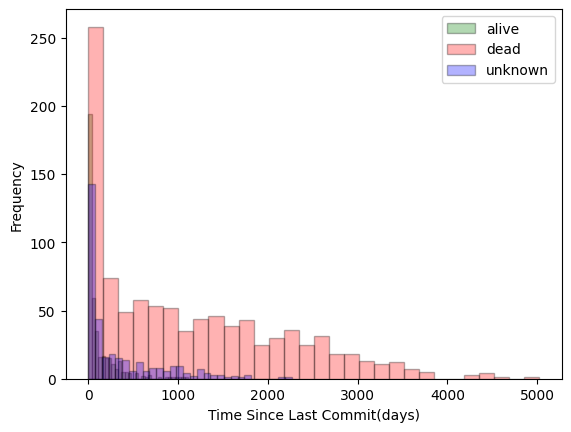

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df

# Plotting
fig, ax = plt.subplots()
colors = {'alive': 'green', 'dead': 'red', 'unknown': 'blue'}  # Example classifications
for classification, color in colors.items():
    data = results_df[results_df['Classification'] == classification]['TimeSinceLastCommit(days)']
    ax.hist(data, bins=30, alpha=0.3, label=classification, color=color, edgecolor='black')

ax.set_xlabel('Time Since Last Commit(days)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


In [ ]:
dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,1332409.20,5.115152,5.507089e+05,dead,858.443900
3,C_2d-inc_developer_quest,6848421.0,127440288.0,6771796.60,24.753252,3.121891e+06,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,207744379.0,37486232.60,97.620000,1.711650e+07,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,128771801.0,356.00,0.004120,NaN,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,57097704.0,22938332.75,68.840289,1.124620e+07,dead,660.853056
...,...,...,...,...,...,...,...,...
1743,C_ziadoz_awesome-php,2537785.0,45455853.0,2212891.00,5.944977,9.425046e+05,dead,526.109410
1745,C_Zoinkwiz_quest-helper,338283.0,1078846.0,312276.60,0.964230,1.301673e+05,dead,12.486644
1748,C_zs9024_quick_psd2ugui,10850856.0,57677255.0,6691764.80,15.090710,3.583334e+06,dead,667.560822
1749,C_zxing_zxing,614301.0,2371857.0,610625.00,3.109478,3.186023e+05,dead,27.452049


#### Unknown

In [ ]:
unknown = results_df[results_df['Classification'] == 'unknown']

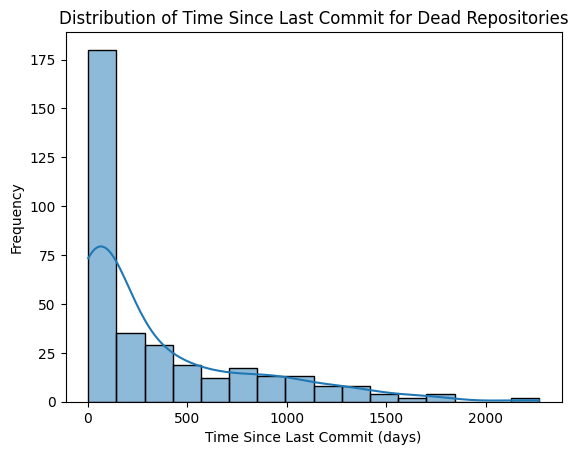

In [ ]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(unknown['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
unknown

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1,C_0xAX_linux-insides,9252379.0,10496672.0,8628677.8,43.319947,3.573628e+06,unknown,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,21445419.6,51.277137,1.028525e+07,unknown,442.272384
13,C_activeadmin_activeadmin,641697.0,661900.0,418692.6,1.003023,2.100131e+05,unknown,7.660880
16,C_adamwulf_Columnizer-jQuery-Plugin,74968706.0,85947524.0,65714318.8,163.469462,2.852998e+07,unknown,994.763009
24,C_AgoraIO-Community_Agora-Flutter-Quickstart,25747689.0,44140144.0,19150687.4,45.843417,8.715099e+06,unknown,510.881296
...,...,...,...,...,...,...,...,...
1734,C_zenoamaro_react-quill,24810990.0,44511875.0,17060352.4,38.898335,8.242134e+06,unknown,515.183738
1738,C_zhaopeiym_quartzui,31150821.0,53174129.0,18698255.4,40.115967,1.038180e+07,unknown,615.441308
1739,C_zhengtianzuo_QtQuickExamples,68831082.0,91388493.0,49636818.4,127.679131,2.268656e+07,unknown,1057.737187
1744,C_zio_zio-quill,1590764.0,1872654.0,1394342.4,3.849660,5.898560e+05,unknown,21.674236


In [ ]:
# Assuming 'dead_repos' and 'alive_repos' are DataFrames that contain the 'commitFrequency' and 'daysSinceLastPush' columns respectively
# We will plot the histograms for both features in one plot for comparison

plt.figure(figsize=(10, 5))

# Plotting 'commitFrequency' for dead repositories
plt.hist(alive_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='alive Repos: Commit Frequency', edgecolor='black')

# Plotting 'daysSinceLastPush' for alive repositories
plt.hist(dead_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='dead Repos: Days Since Last Push', edgecolor='black')

# Adding title, labels, and legend
plt.title('Distribution of  Days Since Last Push')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()



KeyError: 'TimeSinceLastCommit(days)'

<Figure size 1000x500 with 0 Axes>

#### merge datasets

In [ ]:
graph_data=pd.read_csv('../data/ml_data/graph_data_stats.csv', sep=",",index_col=0)
graph_data.drop('index', axis=1, inplace=True)
graph_data.head(1)

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,...,Fun Rt,nloc Rt,Halstead Volume,Maintainability Index,open_close_ratio,daysSinceLastPush,repoAgeDays,commitFrequency,closedIssueRatio,openIssueRatio
0,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,...,0.01,0.06,1831.576017,57.03145,0.061737,0,3849,0.238816,0.941816,0.058147
